In [10]:
import xarray as xr
import gcsfs
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import zarr
import dask.array as dsa
from importlib import reload

In [3]:
gcs = gcsfs.GCSFileSystem(token='anon')
gcsmap = gcsfs.GCSMap('pangeo-ecco/llc/masks/llc_4320_masks.zarr', gcs=gcs)
#mask = xr.open_zarr(gcsmap)
#mask

In [6]:
zgroup = zarr.open_group(gcsmap)

In [8]:
mask = dsa.from_zarr(gcsmap, component='mask_c').astype('bool')
mask

dask.array<astype, shape=(90, 13, 4320, 4320), dtype=bool, chunksize=(1, 13, 4320, 4320)>

In [82]:
index = mask.sum(axis=(2, 3))
index

dask.array<sum-aggregate, shape=(90, 13), dtype=int64, chunksize=(1, 13)>

In [83]:
index = index.compute()

In [92]:
_facet_strides = ((0,3), (3,6), (6,7), (7,10), (10,13))
index_facets = np.array([list(index[:, slice(*stride)].sum(axis=1)) for stride in _facet_strides]).transpose()
index_facets.shape

(90, 5)

In [11]:
from llcreader import random_utils
random_utils = reload(random_utils)

In [12]:
index_cum = random_utils.face_mask_to_facet_index_list(mask)

In [13]:
index_cum

[0,
 30602155,
 54676876,
 68235120,
 109163879,
 140637966,
 171240121,
 195314842,
 208873086,
 249801845,
 281275932,
 311878087,
 335952808,
 349511052,
 390439811,
 421913898,
 452516053,
 476590774,
 490149018,
 531077777,
 562551864,
 593088331,
 617052095,
 630506834,
 671365400,
 702736069,
 733238445,
 757164783,
 770580978,
 811416669,
 842743353,
 873205456,
 897071890,
 910425041,
 951230825,
 982493335,
 1012900517,
 1036704557,
 1049915884,
 1090679932,
 1121886564,
 1152237518,
 1175989376,
 1189115612,
 1229844239,
 1260997777,
 1291293387,
 1314990298,
 1327961666,
 1368646832,
 1399738524,
 1429971598,
 1453600032,
 1466435977,
 1507065309,
 1538078770,
 1568232413,
 1591773562,
 1604395293,
 1644939361,
 1675860918,
 1705943639,
 1729402193,
 1741869003,
 1782327979,
 1813170623,
 1843159862,
 1866520380,
 1878837709,
 1919196195,
 1949959935,
 1979850337,
 2003100083,
 2015229013,
 2055469488,
 2086148293,
 2115947740,
 2139097777,
 2150983604,
 2191066949,
 222164

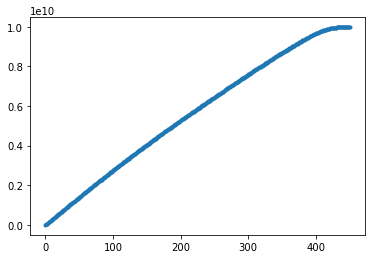

In [14]:
plt.plot(index_cum, '.-')

In [ ]:
ds_index = ((ds.reset_coords()[['hFacC', 'hFacW','hFacS']] > 0)
   .sum(axis=(1, 2, 3)))

In [13]:
mask_2d = mask[0][None]
mask_2d

dask.array<getitem, shape=(1, 13, 4320, 4320), dtype=int8, chunksize=(1, 13, 4320, 4320)>

In [17]:
dsa.concatenate(mask_2d[:, slice(6, 7)], axis=1)

dask.array<getitem, shape=(1, 4320, 4320), dtype=int8, chunksize=(1, 4320, 4320)>

In [37]:
mask_2d

dask.array<getitem, shape=(1, 13, 4320, 4320), dtype=int8, chunksize=(1, 13, 4320, 4320)>

In [20]:

_facet_strides = ((0,3), (3,6), (6,7), (7,10), (10,13))
# whether to reshape each face
_facet_reshape = (False, False, False, True, True)
_nfaces = 13

def _faces_to_facets(data):
    # returns a list of facets
    nz, nf, ny, nx = data.shape
    assert nf == _nfaces
    facets = []
    for nfacet, (strides, reshape) in enumerate(zip(_facet_strides, _facet_reshape)):
        face_data = [data[:, slice(nface, nface+1)] for nface in range(*strides)]
        if reshape:
            concat_axis = 3
        else:
            concat_axis = 2
        # todo: use duck typing for concat
        facet_data = dsa.concatenate(face_data, axis=concat_axis)
        facets.append(facet_data)
    return facets

In [21]:
facets = _faces_to_facets(mask)
facets

[dask.array<concatenate, shape=(90, 1, 12960, 4320), dtype=bool, chunksize=(1, 1, 4320, 4320)>,
 dask.array<concatenate, shape=(90, 1, 12960, 4320), dtype=bool, chunksize=(1, 1, 4320, 4320)>,
 dask.array<getitem, shape=(90, 1, 4320, 4320), dtype=bool, chunksize=(1, 1, 4320, 4320)>,
 dask.array<concatenate, shape=(90, 1, 4320, 12960), dtype=bool, chunksize=(1, 1, 4320, 4320)>,
 dask.array<concatenate, shape=(90, 1, 4320, 12960), dtype=bool, chunksize=(1, 1, 4320, 4320)>]

In [15]:
from llcreader import llcmodel

In [16]:
from fsspec.implementations.local import LocalFileSystem

In [37]:
fs = LocalFileSystem()
path = '/Users/rpa/Code/llcreader/Eta.0000010368.data.shrunk'
dtype = np.dtype('>f4')
nk = 90
nx = 4320

In [38]:
from importlib import reload
llcmodel = reload(llcmodel)
llcmodel

<module 'llcreader.llcmodel' from '/Users/rpa/Code/llcreader/llcreader/llcmodel.py'>

In [48]:
np.ravel_multi_index?

Docstring:
ravel_multi_index(multi_index, dims, mode='raise', order='C')

Converts a tuple of index arrays into an array of flat
indices, applying boundary modes to the multi-index.

Parameters
----------
multi_index : tuple of array_like
    A tuple of integer arrays, one array for each dimension.
dims : tuple of ints
    The shape of array into which the indices from ``multi_index`` apply.
mode : {'raise', 'wrap', 'clip'}, optional
    Specifies how out-of-bounds indices are handled.  Can specify
    either one mode or a tuple of modes, one mode per index.

    * 'raise' -- raise an error (default)
    * 'wrap' -- wrap around
    * 'clip' -- clip to the range

    In 'clip' mode, a negative index which would normally
    wrap will clip to 0 instead.
order : {'C', 'F'}, optional
    Determines whether the multi-index should be viewed as
    indexing in row-major (C-style) or column-major
    (Fortran-style) order.

Returns
-------
raveled_indices : ndarray
    An array of indices into

In [52]:
facets[4][1]

dask.array<getitem, shape=(1, 4320, 12960), dtype=bool, chunksize=(1, 4320, 4320)>

In [54]:
12960 * 4

51840

In [49]:
dr = llcmodel.LLCDataRequest(fs, path, dtype, nk, nx, mask=facets, index=index_cum, klevels=[1])
dr

In [53]:
index_cum

[0,
 30602155,
 54676876,
 68235120,
 109163879,
 140637966,
 171240121,
 195314842,
 208873086,
 249801845,
 281275932,
 311878087,
 335952808,
 349511052,
 390439811,
 421913898,
 452516053,
 476590774,
 490149018,
 531077777,
 562551864,
 593088331,
 617052095,
 630506834,
 671365400,
 702736069,
 733238445,
 757164783,
 770580978,
 811416669,
 842743353,
 873205456,
 897071890,
 910425041,
 951230825,
 982493335,
 1012900517,
 1036704557,
 1049915884,
 1090679932,
 1121886564,
 1152237518,
 1175989376,
 1189115612,
 1229844239,
 1260997777,
 1291293387,
 1314990298,
 1327961666,
 1368646832,
 1399738524,
 1429971598,
 1453600032,
 1466435977,
 1507065309,
 1538078770,
 1568232413,
 1591773562,
 1604395293,
 1644939361,
 1675860918,
 1705943639,
 1729402193,
 1741869003,
 1782327979,
 1813170623,
 1843159862,
 1866520380,
 1878837709,
 1919196195,
 1949959935,
 1979850337,
 2003100083,
 2015229013,
 2055469488,
 2086148293,
 2115947740,
 2139097777,
 2150983604,
 2191066949,
 222164

In [50]:
eta = dr._build_facet_chunk(4)
eta.shape

ValueError: NumPy boolean array indexing assignment cannot assign 0 input values to the 31474087 output values where the mask is true

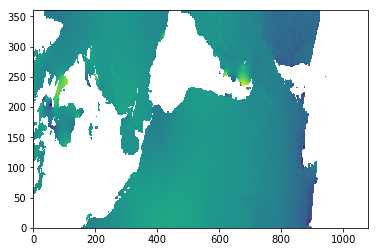

In [45]:
plt.pcolormesh(eta.squeeze()[::12, ::12])

In [69]:
eta_facets = dr.facets()
eta_facets

[dask.array<from-value, shape=(1, 1, 12960, 4320), dtype=>f4, chunksize=(1, 1, 12960, 4320)>,
 dask.array<from-value, shape=(1, 1, 12960, 4320), dtype=>f4, chunksize=(1, 1, 12960, 4320)>,
 dask.array<from-value, shape=(1, 1, 4320, 4320), dtype=>f4, chunksize=(1, 1, 4320, 4320)>,
 dask.array<from-value, shape=(1, 1, 4320, 12960), dtype=>f4, chunksize=(1, 1, 4320, 12960)>,
 dask.array<from-value, shape=(1, 1, 4320, 12960), dtype=>f4, chunksize=(1, 1, 4320, 12960)>]

In [70]:
eta0 = eta_facets[0].compute()

/Users/rpa/Code/llcreader/llcreader/llcmodel.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_blank[mask] = data


ValueError: shape mismatch: value array of shape (55987200,) could not be broadcast to indexing result of shape (12960,4320,12960,4320)

In [49]:
f0 = facets[0].compute()

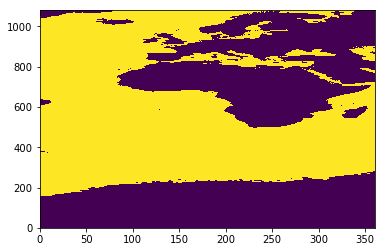

In [50]:
plt.pcolormesh(f0[0, 0, ::12, ::12])

In [51]:
f4 = facets[4].compute()

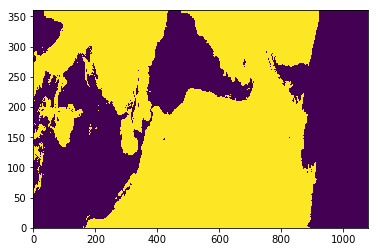

In [53]:
plt.pcolormesh(f4[0, 0, ::12, ::12])